# 你怎麼判斷紅酒的品質，靠味蕾還是機器學習？

- https://reurl.cc/g7y7Ab

In [ ]:
!pip3 install --upgrade yellowbrick

# 載入常用程式庫及定義

In [1]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/My Drive/adventures/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '\\Google Drive\\adventures\\'

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=14)

from datetime import datetime
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import sklearn
assert sklearn.__version__ >= "0.20"
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import sys
# import gdown
import requests
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from pandas.plotting import register_matplotlib_converters

data_dir = groot_dir + 'wine quality\\'
figure_dir = groot_dir + 'wine quality\\'


gfigure = lambda name: figure_dir + name + '.png'
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 300)

local_time = lambda x, offset: x + relativedelta(hours= offset)
def local_now(hours = 8):
    return datetime.now() + relativedelta(hours = hours if in_colab else 0)

def print_now():
    return print(local_now())

def print_local_now():
    return print('Local Time:', local_now())

def fetch_gdrive_file(fid, local_save):
    remote_url = 'https://drive.google.com/uc?id=' + fid
    gdown.download(remote_url, local_save, quiet = False)

def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = save_in_dir + local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath
        
def acct_string(num):
    s0 = str(num)
    if len(s0) <=3:
        return s0  
    num_section = int(len(s0)/3)
    remaining_start = len(s0) % 3
    s = s0[:remaining_start]
    for i in range(num_section):
        s += ',%s' % s0[remaining_start + i*3 :remaining_start + (i+1)*3]   
    return s

TAIWAN_CSV = '1I5yqulrZSHPSQkxT3oqt_3uVAhPolOEP'
RED_WINE = '1ZDg4EfKkkjsWXfs4L3DkZhnAIfnq98Vk'
TITANIC_TRAIN = '1PrxmUKRQWSlYgtMU13l1E0ob4hVJI20O'
JHU_CSSE = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
MNIST_TRAIN = '1E-uJ0zqqAfpsVjoOSzqF5TXhDfPNlkQ5'
MNIST_TRAIN_LABEL = '13clNJ2cd2I90W3DEkDBKjZSDNNEqqx3B'
MNIST_TEST = '1zVpVHJl5YABa3qExt1K-O3WaEHXTJekg'
MNIST_TEST_LABEL = '1qci_-dqubnRN-cdrCsbYaUAxyO7_jH9z'

print('\nThis module is amied to explore wine quality csv...')

print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)
print('Data storage root points to ==>', groot_dir)
print('Wine Quality data will be stored at ==>', data_dir)
print('\nLibraries and dependenciess imported')
print_local_now()


This module is amied to explore wine quality csv...

Running on win32
Python Version 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Data storage root points to ==> C:\Users\TyKA\Google Drive\adventures\
Wine Quality data will be stored at ==> C:\Users\TyKA\Google Drive\adventures\wine quality\

Libraries and dependenciess imported
Local Time: 2021-06-06 11:33:40.620242


# 熱身：sklearn load_wine

- [sklearn datasets](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets)
- [UCI Archive](https://archive.ics.uci.edu/ml/datasets/Wine)

load_xxxx() 傳回的資料是一種叫 bunch 的資料結構，裏面幾個主要欄位的意義是：

- 'features_names': 特徵名，也就是 X 各欄位的名字
- 'target_names': y 的欄位名稱
- ‘data‘： 資料的內容，也就是 X 的所有數值
- ’target‘：標籤，也就是 y 的數值


* 從 sklearn.datasets 載入 load_wine 數據集
* 檢視數據集的 feature_names, target_names

data (178, 13) <class 'numpy.ndarray'>
target (178,) <class 'numpy.ndarray'>
frame <class 'NoneType'>
target_names (3,) <class 'numpy.ndarray'>
DESCR <class 'str'>
feature_names <class 'list'>
------------------------------
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
['class_0' 'class_1' 'class_2']


* 從數據集中取出數據
- Remark: return_X_y 若False顯示輸出 feature_names, target_names, data, target等，若True則僅輸出data 及 target

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


* 在 DataFrame中匯入 target

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


### 各欄位的定義

- malic acid 蘋果酸
- ash acid 灰
- alcalinity of ash 灰的鹼性
- magnesium 鎂
- total phenols 總酚
- nonflavanoid_phenols 非類黃酮
- proanthocyanins 原花青素
- color intensity 顏色強度
- hue 色調
- proline 脯氨酸

### 欄位間的關聯

* 繪製直方圖確認各 feature 數據分佈狀態

<ipython-input-10-eac29e9bb1de>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  wdf.hist(ax = ax)
C:\Users\TyKA\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


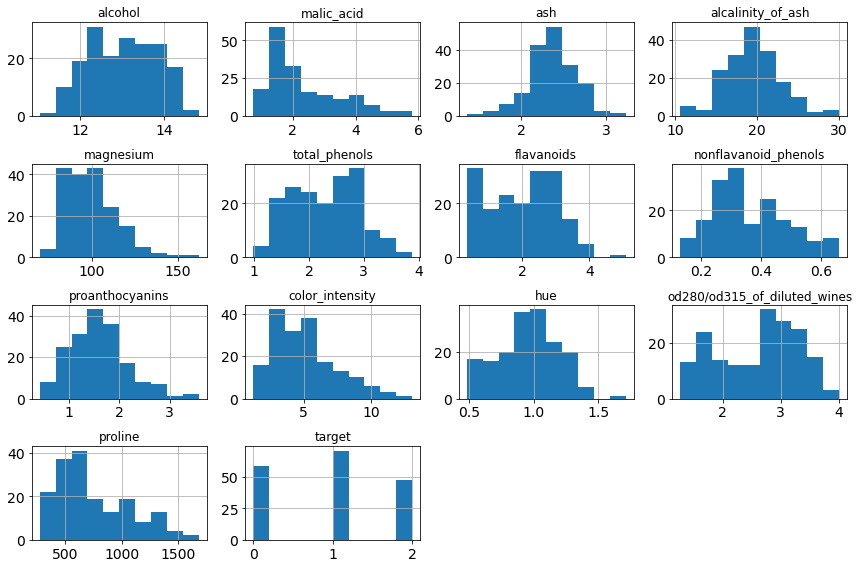

* 求出各 feature 相關係數矩陣，並繪製 seaborn heatmap

<AxesSubplot:>

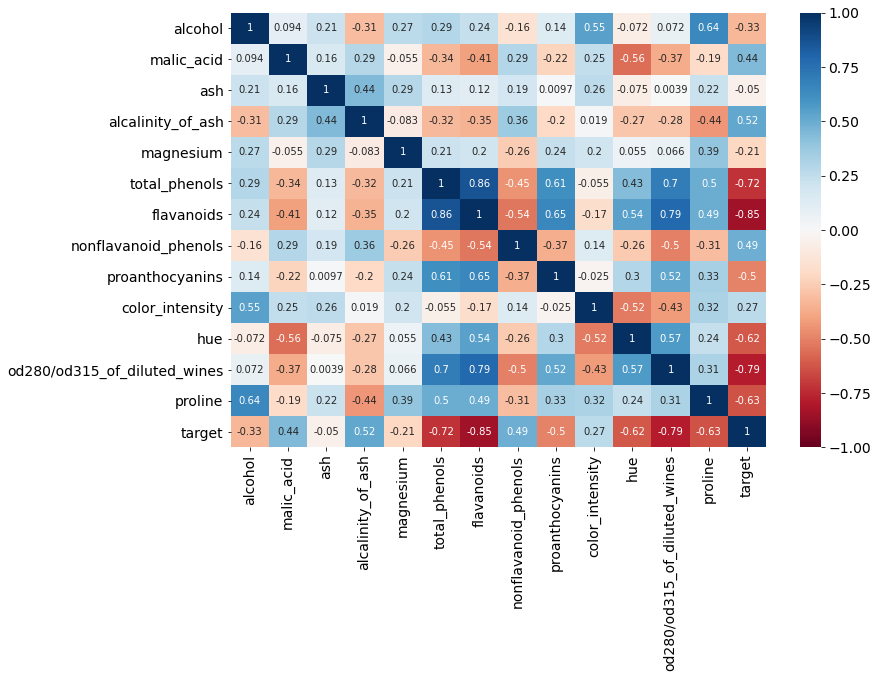

* 取 target 欄位繪製 seaborn countplot

<AxesSubplot:xlabel='target', ylabel='count'>

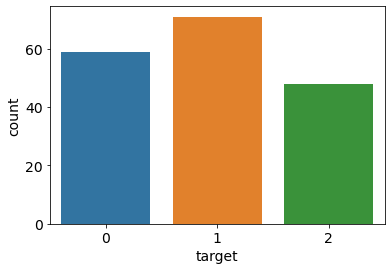

* 以 value_counts() 算 target 中各類數量(補足 countplot上未顯示的數值)

1    71
0    59
2    48
Name: target, dtype: int64

* 取 alcalinity_of_ash 繪製 seaborn distplot

C:\Users\TyKA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='alcalinity_of_ash', ylabel='Density'>

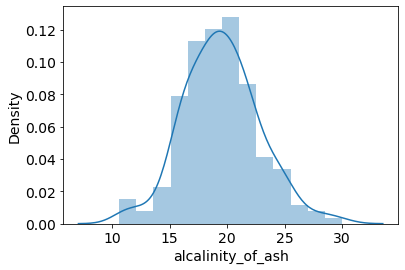

* 取 alcalinity_of_ash 及 target 繪製 seaborn boxenplot

<AxesSubplot:xlabel='alcalinity_of_ash', ylabel='target'>

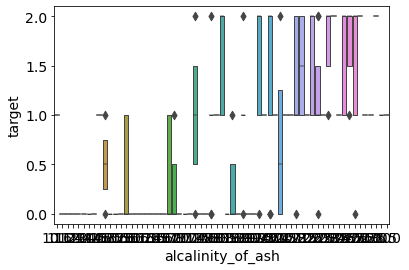

* 以 map 函數新增 class 欄位 (數值取自 target, Ex: 0 → class 0, 1 → class 1, 2 → class 2)
* 取 alcalinity_of_ash 及 class 繪製 seaborn boxplot

<AxesSubplot:xlabel='alcalinity_of_ash', ylabel='class'>

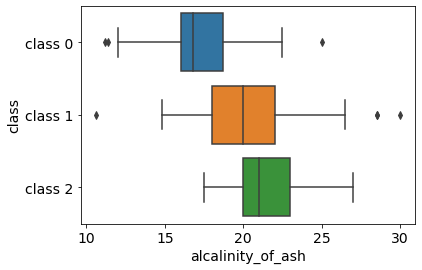

* 取上述數據，繪製 seaborn boxenplot 比較 boxplot 兩者差異

<AxesSubplot:xlabel='alcalinity_of_ash', ylabel='class'>

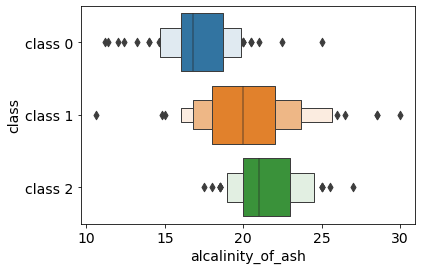

* 取 alcalinity_of_ash 繪製 seaborn kdeplot
* 共繪製 4 條 kdeplot，分別包含 total, class 0, class 1, class 2

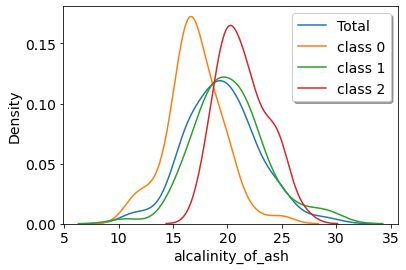

# 第二個資料檔 Wine Quality

- [UCI: Wine Quality](https://archive.ics.uci.edu/ml/datasets/wine+quality)
- [Predicting Wine Quality with Several Classification Techniques](https://towardsdatascience.com/predicting-wine-quality-with-several-classification-techniques-179038ea6434)
- [Wine Quality CSV (kaggle version)](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009)
- [Step-by-step guide for predicting Wine Preferences using Scikit-Learn](https://medium.com/analytics-vidhya/step-by-step-guide-for-predicting-wine-quality-using-scikit-learn-de5869f8f91a)

## 下載 wine quality data

### from UCI repository

* 下載 csv 數據檔
- [wine quality data](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)

### from shared google drive

https://drive.google.com/uc?id=1ZDg4EfKkkjsWXfs4L3DkZhnAIfnq98Vk

- [Pandas DataFrame.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

* 載入 winequality-red.csv 數據 (sep = ";")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


* 檢查數據有無 遺失值(NA)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

- fixed acidity 固定酸度
- volatile acidity 揮發性酸度
- citric acid 檸檬酸
- residual sugar 殘糖
- chlorides 氯化物
- free sulfur dioxide 游離二氧化硫
- total sulfur dioxide 總二氧化硫
- sulphates 硫酸鹽
- alcohol 酒精
- pH 酸鹼值
- density 密度

## Explore Dataset

* 查看 feature names
* 查看 DataFrame information

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


* 確認 數據的基本統計量

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


* 繪製各feature 直方圖確認數據分佈狀態

C:\Users\TyKA\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


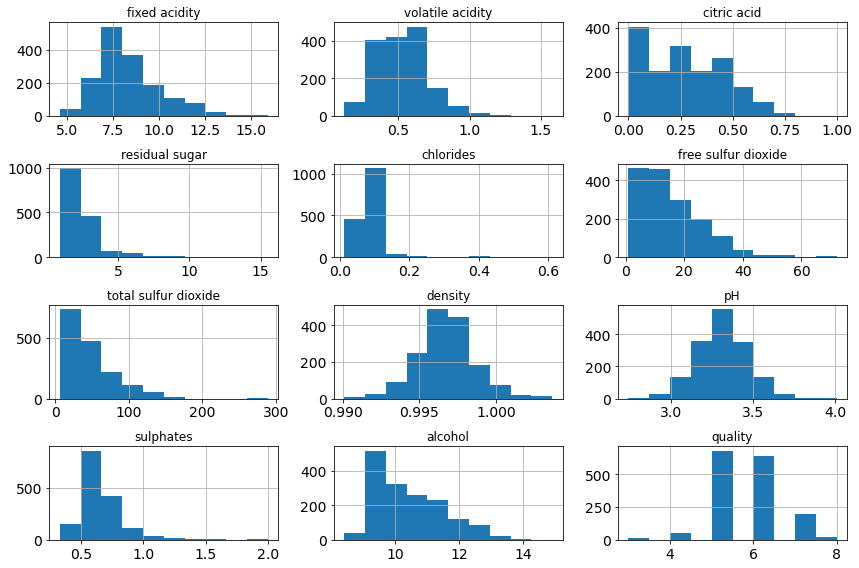

* 取得 DataFrame 的相關係數矩陣，並繪製heatmap
* Note: 設定cbar percentage

cbar = ax.collections[0].colorbar \
cbar.set_ticks(np.arange(-1, 1.25, 0.25)) \
cbar.set_ticklabels(["-100%", "-75%", "-50%", "-25%", "0%", "25%", "50%", "75%", "100%"])

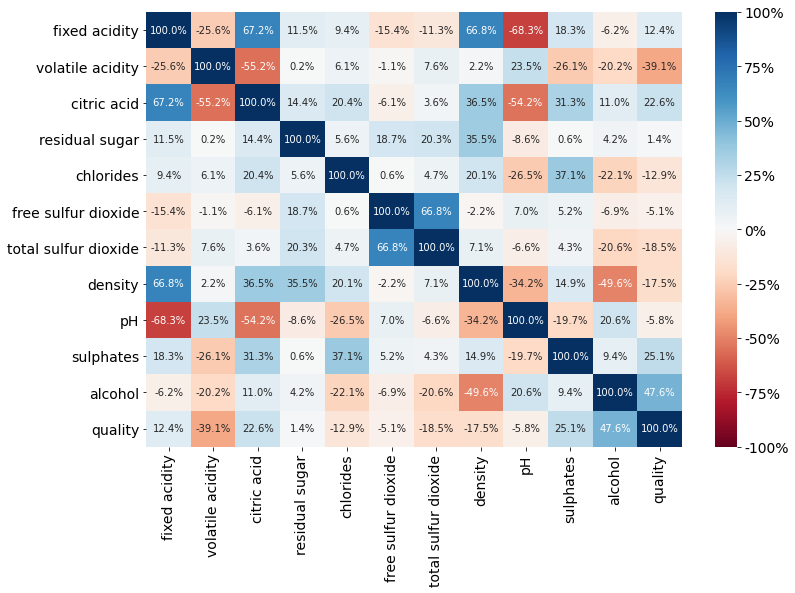

### DataFrame Overview 整體資訊

### 特定欄位的相關資訊

* 嘗試取得 alcohol 平均值

10.422983114446502

* 嘗試取得 alcohol 各數值個數

9.500000     139
9.400000     103
9.800000      78
9.200000      72
10.500000     67
            ... 
11.950000      1
9.233333       1
11.066667      1
13.200000      1
9.566667       1
Name: alcohol, Length: 65, dtype: int64

* 嘗試取得 alcohol 有多少不重複數值

65

* 取 alcohol 繪製 seaborn boxplot

<AxesSubplot:xlabel='alcohol'>

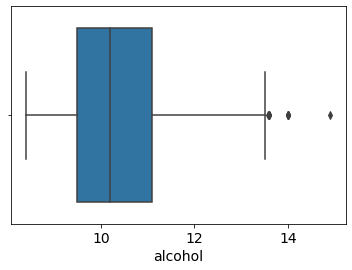

* 取 alcohol 繪製 seaborn distplot

C:\Users\TyKA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='alcohol', ylabel='Density'>

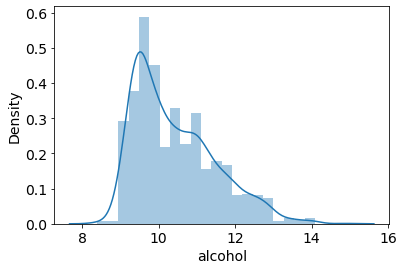

* 確認 quality 分幾級，並繪製 seaborn countplot 

{3, 4, 5, 6, 7, 8}

array([5, 6, 7, 4, 8, 3], dtype=int64)

C:\Users\TyKA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='quality', ylabel='count'>

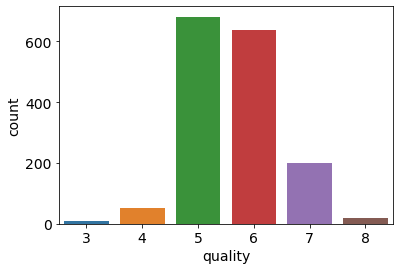

* 確認 quality 各級別個數

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

* 篩出 quality = 8 的數據

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0
mean,8.566667,0.423333,0.391111,2.577778,0.068444,13.277778,33.444444,0.995212,3.267222,0.767778,12.094444,8.0
std,2.119656,0.144914,0.199526,1.295038,0.011678,11.155613,25.433240,0.002378,0.200640,0.115379,1.224011,0.0
min,5.000000,0.260000,0.030000,1.400000,0.044000,3.000000,12.000000,0.990800,2.880000,0.630000,9.800000,8.0
25%,7.250000,0.335000,0.302500,1.800000,0.062000,6.000000,16.000000,0.994175,3.162500,0.690000,11.325000,8.0
50%,8.250000,0.370000,0.420000,2.100000,0.070500,7.500000,21.500000,0.994940,3.230000,0.740000,12.150000,8.0
75%,10.225000,0.472500,0.530000,2.600000,0.075500,16.500000,43.000000,0.997200,3.350000,0.820000,12.875000,8.0
max,12.600000,0.850000,0.720000,6.400000,0.086000,42.000000,88.000000,0.998800,3.720000,1.100000,14.000000,8.0


* 求出 df 各feature相關係數，並取出 quality 對於其他 feature 的相關係數並排序

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

* 取 quality 及 volatile acidity 繪製 seaborn barplot

<AxesSubplot:xlabel='quality', ylabel='volatile acidity'>

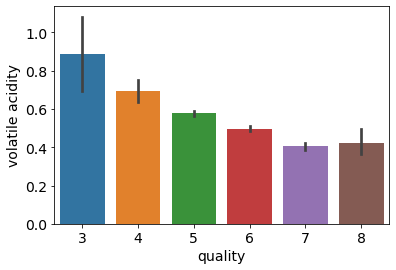

* 取 alcohol 對應不同 quality 繪製 seaborn kdeplot

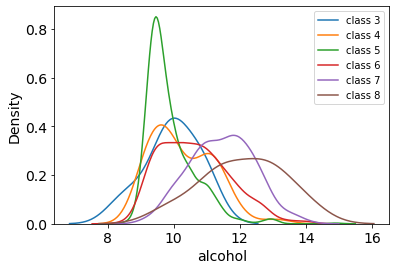

* 取 alcohol 對應 quality = 3 & 8 繪製 kdeplot(q3 & q8) & distplot(total)

C:\Users\TyKA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


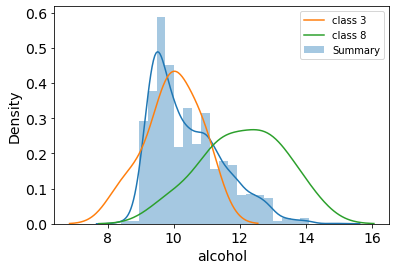

### 兩個欄位之間的關係

## Binay Classification

* 取 quality > 6 的結果存入 y6 (boolean series)

* 將 y6 繪製 seaborn countplot 確認比例

C:\Users\TyKA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='quality', ylabel='count'>

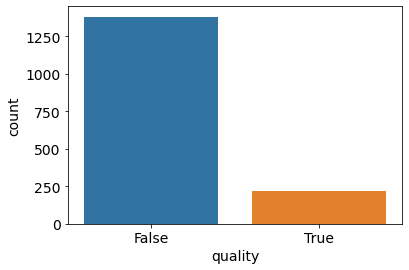

* 使用 pandas.cut 二分法切分數據 \
quality > 6 good, quality < 6 bad

0       bad
1       bad
2       bad
3       bad
4       bad
       ... 
1594    bad
1595    bad
1596    bad
1597    bad
1598    bad
Name: quality, Length: 1599, dtype: category
Categories (2, object): ['bad' < 'good']

* 確認 quality 分類後個別的數量

bad     1382
good     217
Name: quality, dtype: int64

### Select Classifier

* 切分數據集成 x_train, x_tets, y_train, y_test

* 以 MinMaxScalar進行數據轉換，並以 LinearSVC 分類器進行分析，以 classification_report 進行結果確認

In [73]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

              precision    recall  f1-score   support

         bad       0.92      0.97      0.94       355
        good       0.58      0.31      0.41        45

    accuracy                           0.90       400
   macro avg       0.75      0.64      0.67       400
weighted avg       0.88      0.90      0.88       400



* 取 test data 繪製 roc_curve

In [75]:
from sklearn.metrics import plot_roc_curve

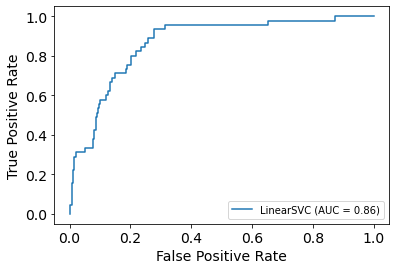

## Comparison of Algorithms

- [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

* 載入各式分類器

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [79]:
models = []
models.append(("LR Classifier", LogisticRegression()))
models.append(("LinearSVC", LinearSVC()))
models.append(("StochasticGD", SGDClassifier()))
models.append(("RandomForest", RandomForestClassifier()))
models.append(("GaussianNB", GaussianNB()))
models.append(("KNeighbors", KNeighborsClassifier()))

In [81]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

* 重新載入數據並切分成 x_train, x_test, y_train, y_test \
* 以 KFold 分成 10 
Note: y 取 y6

C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\TyKA\

LR Classifier done, 0.876


C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

LinearSVC done, 0.875
StochasticGD done, 0.839


C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


RandomForest done, 0.902
GaussianNB done, 0.837
KNeighbors done, 0.863


C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


* 確認 res 結果

LR Classifier
Mean = 0.8757, std = 0.0343
LinearSVC
Mean = 0.8749, std = 0.0347
StochasticGD
Mean = 0.8391, std = 0.0393
RandomForest
Mean = 0.9016, std = 0.0279
GaussianNB
Mean = 0.8366, std = 0.0355
KNeighbors
Mean = 0.8632, std = 0.0304


* 將 res 數據匯入 DataFrame中

,0,1,2,3,4,5,6,7,8,9
0,0.808333,0.875000,0.925000,0.891667,0.858333,0.875000,0.841667,0.908333,0.916667,0.857143
1,0.808333,0.858333,0.933333,0.891667,0.858333,0.875000,0.858333,0.900000,0.916667,0.848739
2,0.750000,0.866667,0.866667,0.866667,0.833333,0.833333,0.816667,0.800000,0.875000,0.882353
3,0.883333,0.875000,0.925000,0.950000,0.875000,0.908333,0.858333,0.925000,0.925000,0.890756
4,0.783333,0.883333,0.875000,0.866667,0.816667,0.825000,0.775000,0.841667,0.833333,0.865546
5,0.841667,0.875000,0.900000,0.891667,0.850000,0.816667,0.825000,0.900000,0.891667,0.840336


* DataFrame 轉置並 以 name 命名 column name 

Text(0.5, 1.0, 'Algorithm Comparison')

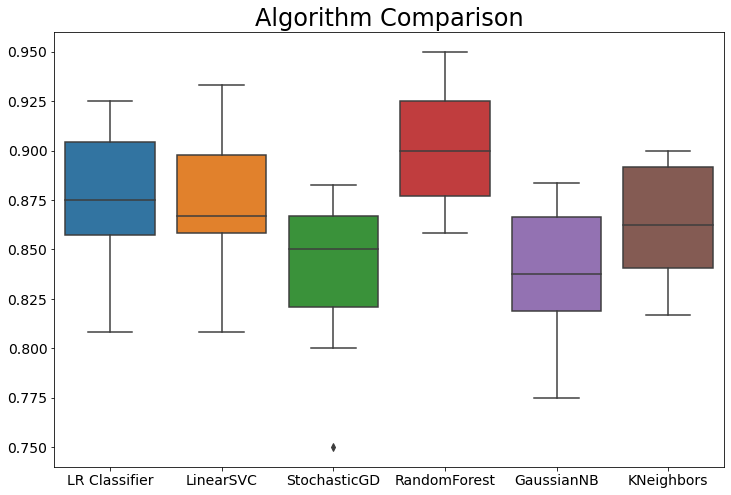

## Tuning Hyperparameters

- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV)
- [kNN API](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier)

In [72]:
X = df.drop(["quality"], axis = 1)
y = y6

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42
)

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def knn_param_selection(X, y, nfolds):
    param = {
        "n_neighbors": [1, 3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "algorithm": ["ball_tree", "kd_tree", "brute"]
    }
    grid_search = GridSearchCV(KNeighborsClassifier(),
                              param_grid=param, 
                              scoring="accuracy",
                              cv = nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_
print(knn_param_selection(x_train, y_train, nfolds=5))

{'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'}


- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=linearsvc#sklearn.svm.LinearSVC)